In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sns.set_theme()

In [3]:
# Get a list of all files which are .csv files in ../DOTSSimulator/Assets/SimulationResults
import os

def get_avg_hrs_per_day(nofish: str) -> float:
    files = [f for f in os.listdir(f'./results/{nofish}') if f.endswith('.csv')]
    # Sort the files descending
    files.sort(reverse=True)

    print(f'Found {len(files)} files')
    print(f'Newest file: {files[0]}')

    compute_times = []
    for f in files:
        result_file_path = f'./results/{nofish}/{f}'
        results_df: pd.DataFrame = pd.read_csv(result_file_path)
        # Print basic information about the dataframe
        # print(results_df.info())

        results_df['DistanceFromLast'] = results_df['TimeStamp'].diff()
        truncated_df = results_df.iloc[1:25]


        # print(truncated_df.describe())

        # print(truncated_df.head())

        compute_times.extend(truncated_df['DistanceFromLast'].to_numpy())

    return np.mean(compute_times), np.std(compute_times)

In [4]:
configs = [1,5,10,25,50,100,200,300, 1000]

means = []
stds = []
for config in configs:
    mean, std = get_avg_hrs_per_day(str(config))
    means.append(mean)
    stds.append(std)

results_df = pd.DataFrame({'NumberOfFish': configs, 'Mean': means, 'Std': stds})
results_df['min_std'] = results_df['Mean'] - results_df['Std']
results_df['max_std'] = results_df['Mean'] + results_df['Std']

results_df

Found 5 files
Newest file: 2023-07-25-13-52-53.csv
Found 5 files
Newest file: 2023-07-25-14-08-54.csv
Found 5 files
Newest file: 2023-07-25-14-20-44.csv
Found 5 files
Newest file: 2023-07-25-14-33-40.csv
Found 5 files
Newest file: 2023-07-25-14-52-57.csv
Found 5 files
Newest file: 2023-07-25-15-15-10.csv
Found 5 files
Newest file: 2023-07-25-16-11-31.csv
Found 5 files
Newest file: 2023-07-25-16-58-35.csv
Found 2 files
Newest file: 2023-07-25-18-16-37.csv


,NumberOfFish,Mean,Std,min_std,max_std
0,1,3.153907,0.143143,3.010764,3.297050
1,5,3.262383,0.083418,3.178965,3.345801
2,10,3.529212,0.035818,3.493393,3.565030
3,25,4.454227,0.030261,4.423966,4.484487
4,50,5.983710,0.034743,5.948967,6.018453
5,100,8.399956,0.138504,8.261452,8.538460
6,200,13.756388,0.094376,13.662012,13.850765
7,300,20.208047,0.081429,20.126618,20.289475
8,1000,84.808958,0.520322,84.288636,85.329281


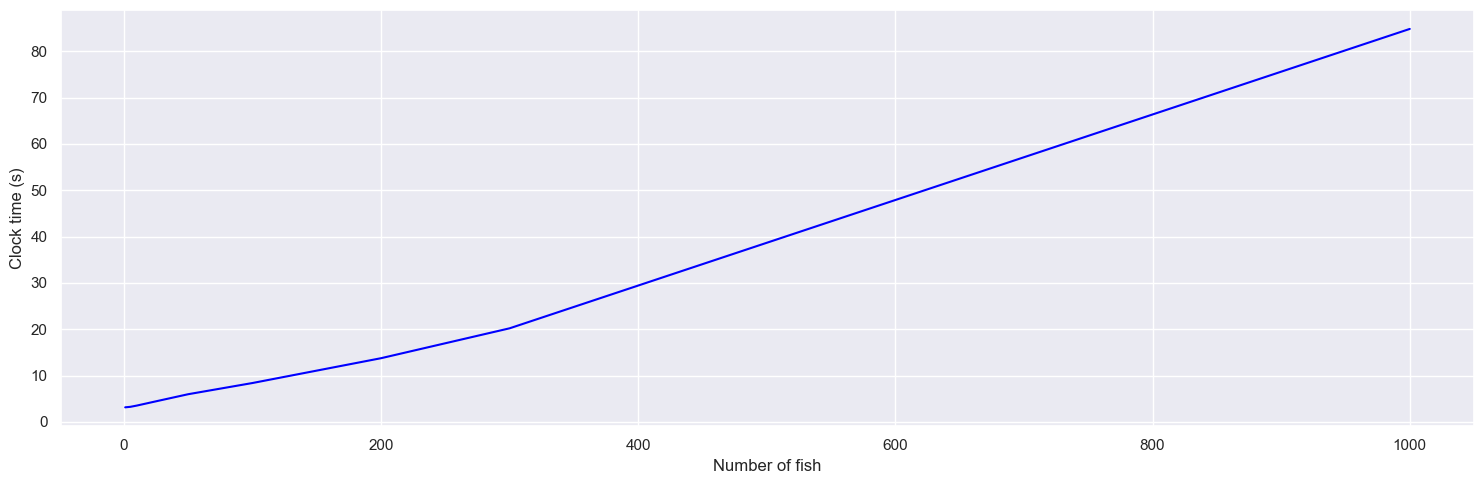

In [5]:
fig = plt.figure(figsize=(15, 5))

ax = fig.add_subplot()
sns.lineplot(data=results_df, x='NumberOfFish', y='Mean', color='blue', ax=ax)
plt.ylabel('Clock time (s)')
plt.xlabel('Number of fish')
plt.tight_layout()
 
plt.savefig('plots/benchmark-1.pdf')